# Demo 3: Building Your First MLP with `nn.Sequential`

Not all problems can be solved with a single decision boundary. Some patterns require complex, curved separations that no single neuron can create. The solution? Stack multiple layers together to build depth.

That's exactly what you're about to discover: how combining layers into a multi-layer perceptron (MLP) unlocks the ability to solve complex patterns, and how PyTorch makes building these architectures remarkably simple.

> **Overview**: Build your first multi-layer perceptron (MLP) using PyTorch's `nn.Sequential`. You'll see how stacking layers finally solves XOR, then apply the same principles to real data.
> 
> **Scenario**: Your restaurant chain spends weeks manually analyzing potential locations. You need a rapid scoring system that considers multiple factors simultaneously: cuisine competition, price points, and local demographics. Instead of wiring neurons manually, you'll use PyTorch to quickly prototype different network architectures.
> 
> **Goal**: Understand how to construct multi-layer networks efficiently and why depth enables solving complex patterns.
> 
> **Tools**: Python, PyTorch, NumPy, Pandas, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and preparing our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory
output_dir = 'assets/demo3'
os.makedirs(output_dir, exist_ok=True)

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")

Setup complete!
PyTorch version: 2.5.1+cu121


## Step 2: Define the MLP architecture

PyTorch provides [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html) as a streamlined container for stacking layers.

Think of this as a manufacturing assembly line: data enters at the top, flows through each station (layer) in a specific order, and emerges transformed at the end. We will construct a 2-layer MLP by defining the sequence of operations.

In [2]:
# Create a 2-layer multi-layer perceptron
model = nn.Sequential(
    nn.Linear(2, 2),      # First layer: 2 inputs → 2 hidden neurons
    nn.Sigmoid(),         # Activation function for non-linearity
    nn.Linear(2, 1),      # Second layer: 2 hidden neurons → 1 output
    nn.Sigmoid()          # Final activation for binary output (0 to 1)
)

print("Created a 2-layer MLP!")
print("\nModel architecture:")
print(model)

Created a 2-layer MLP!

Model architecture:
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


> **The power of `nn.Sequential`: Automatic parameter management.** Notice we didn't write any loops, manage connections between layers, or track which layer feeds into which. `nn.Sequential` automatically creates weights+bias vectors for each layer and chains everything: the output of layer 0 becomes the input of layer 1, and so on. This is composability: stack layers together like Lego blocks, and let PyTorch handle all the underlying orchestration!
> 
> _**Expert insight: When not to use `nn.Sequential`.**_ This simple container is perfect for straightforward layer stacking like we're doing here, and your default choice. Only for more complex architectures with branching, skip connections, or custom logic, you'd need to [define a custom class](https://docs.pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html) that inherits from `nn.Module` instead. 

## Step 3: Understand the MLP architecture

When you printed the model, PyTorch showed you its architecture. Let's decode what that output means:

- **Sequential**: A container that runs layers in numbered order (0 → 1 → 2 → 3)

- **Layer 0 - Linear(in_features=2, out_features=2, bias=True)** - The Hidden Layer:

    - Takes 2 inputs, produces 2 outputs
    - "Fully connected": every input connects to every output
    - Creates a 2×2 weight matrix + 2 bias values = 6 parameters

- **Layer 1 - Sigmoid()**:

    - Non-linear activation function (no parameters)
    - Transforms each of the 2 outputs from Layer 0

- **Layer 2 - Linear(in_features=2, out_features=1, bias=True)**:

    - Takes 2 inputs (from Layer 1), produces 1 output
    - Creates a 1×2 weight matrix + 1 bias value = 3 parameters

- **Layer 3 - Sigmoid()**:

    - Final activation to produce output between 0 and 1

> <details>
> <summary><b>Question</b>: How many parameters does the model have?</summary>
> <b>Total</b>: 6 + 3 = 9 trainable parameters in this network
> 
> <b>How to cound parameters</b>: For any `nn.Linear(in_features, out_features),` the parameter count is `(in_features × out_features) + out_features` <i>(e.g., for layer 1, `2x2+2=6`)</i>. The first term is the weight matrix, the second is the bias vector.
> </details>

#### Count model parameters programmatically

While you can count parameters by hand for small networks, PyTorch provides a way to do it automatically - let's see how!

In [3]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_params}")

# See parameters layer by layer
print("\nParameter breakdown:")
for i, layer in enumerate(model):
    if isinstance(layer, nn.Linear):
        layer_params = layer.weight.numel() + layer.bias.numel()
        print(f"  Layer {i} ({layer}): {layer_params} parameters")
        print(f"    → Weights: {layer.weight.shape} = {layer.weight.numel()}")
        print(f"    → Biases: {layer.bias.shape} = {layer.bias.numel()}")

Total trainable parameters: 9

Parameter breakdown:
  Layer 0 (Linear(in_features=2, out_features=2, bias=True)): 6 parameters
    → Weights: torch.Size([2, 2]) = 4
    → Biases: torch.Size([2]) = 2
  Layer 2 (Linear(in_features=2, out_features=1, bias=True)): 3 parameters
    → Weights: torch.Size([1, 2]) = 2
    → Biases: torch.Size([1]) = 1


> **Why parameter count matters**: The parameter count is a proxy for your model's **capacity** (how much it can memorize) and **cost** (memory and compute required).Understanding how to count them helps you design networks that fit your problem complexity while meeting computational budget.

## Step 4: Solving the XOR challenge

Let's revisit the classic XOR problem to demonstrate how an MLP enables solving patterns that single layers cannot handle.

### Step 4.1: Recap the XOR challenge

The XOR pattern requires separating opposite corners —> no single straight line can do this.

> **Feel free to skip to step 4.2 if you're comfortable with the XOR challenge.**

In [4]:
# 1. Generate dense XOR data (Blobs around the 4 corners)
n_samples = 200

# Create 4 centers: (0,0), (0,1), (1,0), (1,1)
centers = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)

# Repeat centers to create samples
X_xor = centers.repeat(n_samples // 4, 1)

# Add Gaussian noise (jitter) to make it a "cloud" of points
noise = torch.randn(X_xor.shape) * 0.1
X_xor += noise

# Generate Labels: XOR logic based on nearest integer corner
# Logic: (x1 > 0.5) XOR (x2 > 0.5)
y_xor = ((X_xor[:, 0] > 0.5) ^ (X_xor[:, 1] > 0.5)).float().unsqueeze(1)

print(f"Created XOR dataset with {n_samples} points")
print(f"Class distribution: {y_xor.sum():.0f} class 1, {(1-y_xor).sum():.0f} class 0")



Created XOR dataset with 200 points
Class distribution: 100 class 1, 100 class 0


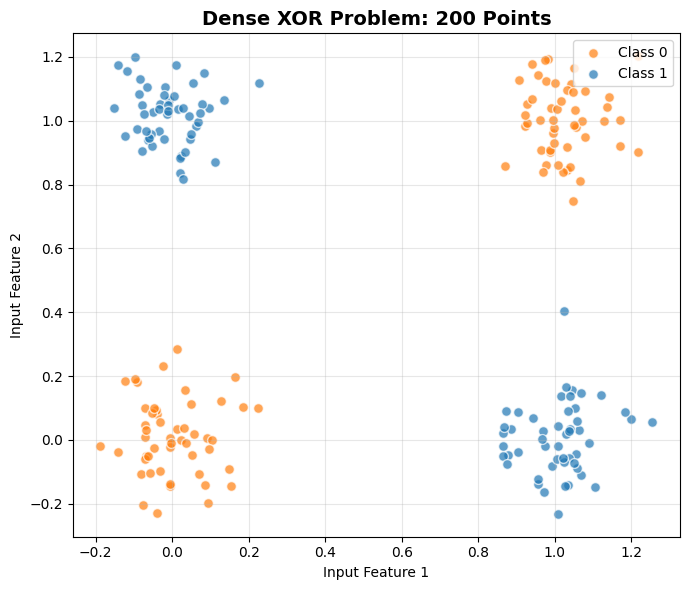


The Challenge: No single straight line can separate these classes!
We need a multi-region boundary, which requires multiple layers.


In [5]:
# 2. Visualize the  XOR problem
plt.figure(figsize=(7, 6))
colors = ['#ff7f0e', '#1f77b4'] # Orange (0), Blue (1)
labels_text = ['Class 0', 'Class 1']

for cls in range(2):
    mask = (y_xor.squeeze() == cls)
    plt.scatter(
        X_xor[mask, 0], X_xor[mask, 1],
        c=colors[cls],
        s=50,
        alpha=0.7,
        label=labels_text[cls],
        edgecolors='white'
    )

plt.xlabel('Input Feature 1')
plt.ylabel('Input Feature 2')
plt.title('Dense XOR Problem: 200 Points', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("\nThe Challenge: No single straight line can separate these classes!")
print("We need a multi-region boundary, which requires multiple layers.")

> **Why XOR matters**: This simple 4-point problem stumped early neural networks. The pattern requires separating opposite corners, which is something no single straight line can do. Understanding why single neurons fail here is key to understanding why we need depth.

### Step 4.2: Configure weights to solve XOR

For demonstration purposes, we'll manually set the weights to values that solve XOR:
1. **Neuron 1 (OR-like)**: Fires if _at least one_a input is roughly > 0.5
2. **Neuron 2 (NAND-like)**: Fires if _anot both_a inputs are roughly > 0.5
3. **Output (AND-like)**: Combines them. If (OR is True) AND (NAND is True), then it's XOR.

This shows that the architecture is capable of representing the solution.

In [6]:
# Manually set weights to solve the problem logic
with torch.no_grad():
    # Layer 0: Feature Extraction
    # Neuron 0: Detects if x1 OR x2 is active (> 0.5)
    # Neuron 1: Detects if inputs are NOT BOTH active (< 1.5)
    model[0].weight.copy_(torch.FloatTensor([
        [20.0, 20.0],   # Weights for OR-like neuron
        [-20.0, -20.0]  # Weights for NAND-like neuron
    ]))
    # Biases shift the decision boundary
    model[0].bias.copy_(torch.FloatTensor([-10.0, 30.0]))
    
    # Layer 2: Combination (AND)
    # Activates only if BOTH hidden neurons are active
    model[2].weight.copy_(torch.FloatTensor([[20.0, 20.0]]))
    model[2].bias.copy_(torch.FloatTensor([-30.0]))

print("Manual weights applied.")

# Test the model
with torch.no_grad():
    predictions = model(X_xor)
    predicted_classes = (predictions > 0.5).float()
    accuracy = (predicted_classes == y_xor).float().mean().item()

print(f"\nPerformance on dense dataset:")
print(f"Accuracy: {accuracy:.1%}")

# Show a few specific examples
print("\nSample predictions:")
print(f"Input (0.1, 0.1) -> Pred: {model(torch.tensor([[0.1, 0.1]])).item():.4f} (Class 0)")
print(f"Input (0.1, 0.9) -> Pred: {model(torch.tensor([[0.1, 0.9]])).item():.4f} (Class 1)")


Manual weights applied.

Performance on dense dataset:
Accuracy: 100.0%

Sample predictions:
Input (0.1, 0.1) -> Pred: 0.0000 (Class 0)
Input (0.1, 0.9) -> Pred: 1.0000 (Class 1)


> **How it works**: The first layer transforms the 2D input space into a new 2D space where the pattern becomes linearly separable. The first neuron detects "at least one input is 1" (OR-like), while the second neuron detects "not both inputs are 1" (NAND-like). The second layer then combines these two patterns with an AND operation, producing XOR: output is 1 when (at least one is 1) AND (not both are 1).
> 
> This is the power of depth: each layer re-represents the problem, making it easier for the next layer.

### Step 4.3: Visualize how the MLP layers transform the problem

How did the network solve this non-linear problem using linear layers? Let's see how the network transforms the XOR problem from unsolvable to solvable through its layers.

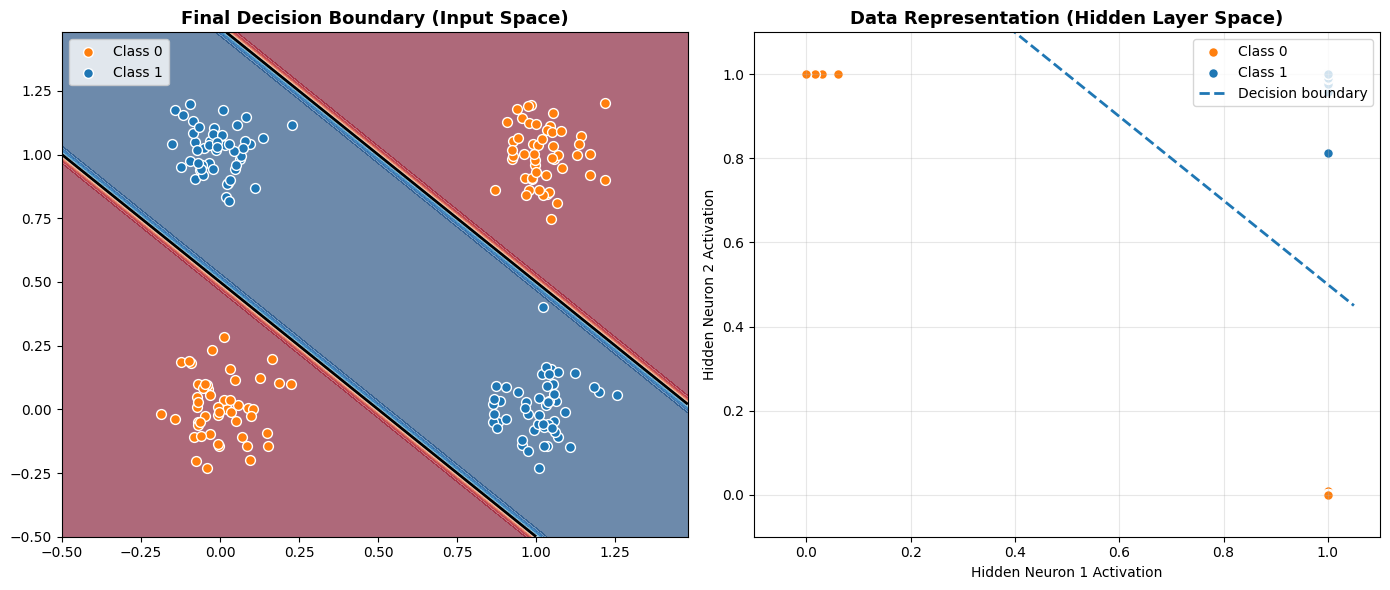

Insights:
1. The Input Space (Left) shows a 'curved' boundary solving the XOR logic.
2. The Hidden Space (Right) shows that the network moved the points so a straight line CAN separate them.


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- LEFT: Decision Boundary in Input Space ---
ax = axes[0]

# Create a meshgrid to visualize the boundary
h = 0.02
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

with torch.no_grad():
    Z = model(grid_tensor).reshape(xx.shape)

# Contour plot
contour = ax.contourf(xx, yy, Z, levels=20, cmap='RdBu', alpha=0.6)
ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Scatter plot of data
for cls in range(2):
    mask = (y_xor.squeeze() == cls)
    ax.scatter(X_xor[mask, 0], X_xor[mask, 1], c=colors[cls],
               edgecolors='white', s=50, label=f'Class {cls}')

ax.set_title("Final Decision Boundary (Input Space)", fontsize=13, fontweight='bold')
ax.legend(loc='upper left')

# --- RIGHT: Transformed Space (Hidden Layer) ---
ax = axes[1]

with torch.no_grad():
    # Pass data through just the first layer + sigmoid
    hidden_layer_output = nn.Sequential(model[0], model[1])(X_xor)

for cls in range(2):
    mask = (y_xor.squeeze() == cls)
    ax.scatter(
        hidden_layer_output[mask, 0],
        hidden_layer_output[mask, 1],
        c=colors[cls],
        edgecolors='white',
        s=50,
        label=f'Class {cls}'
    )

# --- Add linear decision boundary in hidden space ---
with torch.no_grad():
    # Get weights and bias of the final linear layer
    w = model[2].weight[0]   # shape: (2,)
    b = model[2].bias[0]     # scalar

    # Use range of hidden activations for the x-axis of the line
    h1_min = hidden_layer_output[:, 0].min().item()
    h1_max = hidden_layer_output[:, 0].max().item()

    line_x = torch.linspace(h1_min - 0.05, h1_max + 0.05, 100)

    # Solve w1 * h1 + w2 * h2 + b = 0  →  h2 = -(w1 * h1 + b) / w2
    if torch.abs(w[1]) > 1e-6:  # avoid divide-by-zero
        line_y = (-(w[0] * line_x + b) / w[1])

        ax.plot(
            line_x.numpy(),
            line_y.numpy(),
            linestyle='--',
            linewidth=2,
            label='Decision boundary'
        )

# Nicely frame the hidden activations
h2_min = hidden_layer_output[:, 1].min().item()
h2_max = hidden_layer_output[:, 1].max().item()
ax.set_xlim(h1_min - 0.1, h1_max + 0.1)
ax.set_ylim(h2_min - 0.1, h2_max + 0.1)

ax.set_title("Data Representation (Hidden Layer Space)", fontsize=13, fontweight='bold')
ax.set_xlabel("Hidden Neuron 1 Activation")
ax.set_ylabel("Hidden Neuron 2 Activation")
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Insights:")
print("1. The Input Space (Left) shows a 'curved' boundary solving the XOR logic.")
print("2. The Hidden Space (Right) shows that the network moved the points so a straight line CAN separate them.")

> **The geometry of depth**: Look at the right plot. In the original space, you cannot draw a straight line to separate orange from blue. However, after the first layer processes the data, the blue points are pushed to the center and the orange points to the edges. In this _new_ space, they are linearly separable.
> 
> This is the fundamental insight of deep learning: each layer learns a representation that makes the problem easier for subsequent layers.

## Step 5: Scale to real-world data

Now let's apply these same principles to the real-world problem in our scenario: predicting restaurant success based on multiple features.

_Spoiler: The architecture approach is identical: only the input size changes!_

### Step 5.1 Load and process the data

We'll use the [MongoDB/whatscooking.restaurants](https://huggingface.co/datasets/MongoDB/whatscooking.restaurants) dataset from Hugging Face, which contains detailed information on restaurants across New York City.

For preprocessing, we'll:

1. Load the dataset from Hugging Face
2. Remove rows with null values for key features
3. Encode categorical variables (cuisine, borough) as numbers
4. Extract key features: stars, review_count, PriceRange, cuisine, borough
5. Normalize features for the neural network
6. Create binary success labels: high rating (4+ stars) AND proven popularity (50+ reviews)
7. Create the final feature and label datasets _(in tensor format)_

**IMPORTANT: Feel free to skip this data preparation section to focus on the MLP architecture itself**. Just know that we end up with a few thousand restaurants, each with 5 features (stars, reviews, price, encoded cuisine, encoded borough) always populated, and a binary success label.

In [8]:
# 1. Load restaurant data from HuggingFace
print("Loading restaurant dataset...")
dataset = load_dataset("MongoDB/whatscooking.restaurants", split="train")
df = pd.DataFrame(dataset)

print(f"Total restaurants in dataset: {len(df):,}")
print(f"\nDataset columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"\nFirst few entries:")
print(df[['name', 'cuisine', 'stars', 'review_count', 'borough']].head())

Loading restaurant dataset...
Total restaurants in dataset: 25,361

Dataset columns: ['restaurant_id', 'location', '_id', 'review_count', 'DogsAllowed', 'embedding', 'PriceRange', 'menu', 'HappyHour', 'TakeOut']...

First few entries:
                     name   cuisine  stars  review_count        borough
0      Baby Bo'S Burritos   Tex-Mex    2.5            10      Manhattan
1      Buddy'S Wonder Bar  American    3.5            62  Staten Island
2  Great Kills Yacht Club  American    4.0            72  Staten Island
3        Keats Restaurant  American    4.0           149      Manhattan
4                 Olive'S    Bakery    5.0             7      Manhattan


In [9]:
# 2. Remove entries with any null value
df = df.dropna(subset=['stars', 'review_count', 'PriceRange', 'cuisine', 'borough'])

# 3. Encode categorical features
cuisine_encoder = LabelEncoder()
borough_encoder = LabelEncoder()

df['cuisine_encoded'] = cuisine_encoder.fit_transform(df['cuisine'])
df['borough_encoded'] = borough_encoder.fit_transform(df['borough'])

# 4. Select subset of features
feature_columns = ['stars', 'review_count', 'PriceRange', 'cuisine_encoded', 'borough_encoded']
df = df[feature_columns]

# 5. Normalize features (important for neural networks!)
scaler = StandardScaler()
X_raw = df.to_numpy()
X_scaled = scaler.fit_transform(X_raw)

# 6. Create success label: high rating (4+ stars) AND proven popularity (50+ reviews)
df['success'] = ((df['stars'] >= 4.0) & 
                        (df['review_count'] >= 50)).astype(int)
y = df['success'].values

# 7. Define final datasets as PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y).unsqueeze(1)

print(f"Prepared {X_tensor.shape[0]} restaurants with {X_tensor.shape[1]} features")
print(f"\nFeature names: {feature_columns}")
print(f"Target: success (0 or 1)")
print(f"Success rate: {df['success'].mean():.1%}")

Prepared 22947 restaurants with 5 features

Feature names: ['stars', 'review_count', 'PriceRange', 'cuisine_encoded', 'borough_encoded']
Target: success (0 or 1)
Success rate: 23.3%


> **Understanding data preparation for neural networks:**
> 
> - **Encoding categorical features**: Neural networks only understand numbers, not text. We converted cuisine types (e.g., "Italian", "Chinese") and boroughs (e.g., "Manhattan", "Brooklyn") into numerical codes (0, 1, 2, ...). This is called label encoding: each unique category gets a unique integer.
> 
> - **Normalization**: We scaled all features to have similar ranges using standardization (mean=0, standard deviation=1). Why? Features like `review_count` (range: 5-9185) would dominate features like `stars` (range: 1-5) without normalization. Neural networks learn better when all inputs are on comparable scales.
> 
> **The result**: Just like XOR, we now have numerical data that the network can process: features in columns, examples in rows, all as numbers. The difference? XOR had 2 simple binary features. Our restaurant data has 5 features with richer patterns: continuous values (stars, reviews), ordinal values (price), and encoded categories (cuisine, borough). Same data structure, but with more complexity.

### Step 5.2: Adapt the MLP to the new use case

Now we'll adjust our existing MLP architecture to work for this more complex real-world problem.


In [10]:
# Create a 2-layer MLP for restaurant prediction
input_size = X_tensor.shape[1]  # Number of features
hidden_size = 10                # Number of neurons in hidden layer
output_size = 1                 # Binary classification (success or not)

model_restaurant = nn.Sequential(
    nn.Linear(input_size, hidden_size),   # First layer: features → hidden neurons
    nn.Sigmoid(),                         # Non-linearity
    nn.Linear(hidden_size, output_size),  # Second layer: hidden → output
    nn.Sigmoid()                          # Output between 0 and 1
)

print("Created restaurant success predictor!")
print("\nModel architecture:")
print(model_restaurant)
print("\nLayer details:")
print(f"  Input layer: {input_size} features")
print(f"  Hidden layer: {hidden_size} neurons")
print(f"  Output layer: {output_size} neuron (success probability)")

# Count parameters
total_params = sum(p.numel() for p in model_restaurant.parameters())
print(f"\nTotal parameters: {total_params}")

Created restaurant success predictor!

Model architecture:
Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)

Layer details:
  Input layer: 5 features
  Hidden layer: 10 neurons
  Output layer: 1 neuron (success probability)

Total parameters: 71


> <details>
> <summary><strong>Noticed the differences between the XOR and real data models?</strong></summary>
> 
> <br>
> 
> **What changed:**
> - Input size: 2 features (XOR) → 5 features (restaurants)
> - Hidden layer size: 2 neurons (XOR) → 10 neurons (restaurants)
> - Parameters: 9 (XOR) → 71 (restaurants)
> 
> **What stayed the same:**
> - Architecture pattern: Input → Linear → Sigmoid → Linear → Sigmoid
> - Number of layers: 2 layers in both
> - Building approach: Stack layers with `nn.Sequential`
> 
> **The key insight**: The MLP architecture is flexible. To handle more complex data, we simply adjusted the layer sizes (`nn.Linear(2, 2)` became `nn.Linear(5, 10)`). The fundamental pattern—stack layers, add activation functions, connect inputs to outputs—remains identical regardless of problem size. This is why `nn.Sequential` is so powerful: the same design principles scale from toy problems to real-world datasets.
> 
> </details>

### Step 5.3: Test the network with random weights

Let's see what happens when we pass data through the network with its randomly initialized weights.

In [11]:
# Get predictions on a small sample
sample_size = 10
sample_X = X_tensor[:sample_size]
sample_y = y_tensor[:sample_size]

with torch.no_grad():
    predictions = model_restaurant(sample_X)
    predicted_classes = (predictions > 0.5).float()

print("Predictions with random weights:\n")
print("Restaurant | Actual Success | Predicted Prob | Predicted Class")
print("-" * 70)
for i in range(sample_size):
    actual = sample_y[i].item()
    pred_prob = predictions[i].item()
    pred_class = predicted_classes[i].item()
    print(f"    {i:2d}     |       {actual:.0f}        |     {pred_prob:.4f}      |       {pred_class:.0f}")

accuracy = (predicted_classes == sample_y).float().mean().item()
print(f"\nAccuracy on sample: {accuracy:.1%}")
print(f"  • Model predicts success {predicted_classes.mean().item():.0%} of the time")
print(f"  • Actual success rate is only {sample_y.mean().item():.0%} in this sample")
print("\nNote: Random weights give predictions clustered around 0.5 (uncertain guessing).")

Predictions with random weights:

Restaurant | Actual Success | Predicted Prob | Predicted Class
----------------------------------------------------------------------
     0     |       0        |     0.5521      |       1
     1     |       0        |     0.5711      |       1
     2     |       1        |     0.5686      |       1
     3     |       1        |     0.5830      |       1
     4     |       0        |     0.5930      |       1
     5     |       0        |     0.5910      |       1
     6     |       0        |     0.5951      |       1
     7     |       0        |     0.5624      |       1
     8     |       1        |     0.5915      |       1
     9     |       0        |     0.5790      |       1

Accuracy on sample: 30.0%
  • Model predicts success 100% of the time
  • Actual success rate is only 30% in this sample

Note: Random weights give predictions clustered around 0.5 (uncertain guessing).


> **Why random weights fail**: The network architecture is correct, but the weights are initialized randomly. Just like our XOR solution needed specific weights, this restaurant predictor needs to learn the right weights from data. That's what model training does: it adjusts the weights to find an optimal combination that minimizes prediction errors!

## Conclusion

Congratulations! You've built your first multi-layer perceptrons using PyTorch's `nn.Sequential`. 

Let's recap what you've discovered:

1. **nn.Sequential is the layer assembly line:** Stack layers in order, PyTorch handles all the connections  
2. **nn.Linear is the building block:** Fully connected layers that PyTorch creates and manages for you  
3. **Depth enables complexity:** Multiple layers can solve problems (like XOR) that single layers cannot  
4. **Layers transform representations:** The first layer reshapes the problem to make it easier for the second layer  
5. **Architecture scales effortlessly:** Going from 2 inputs to 5 inputs required changing one number  
6. **Architecture ≠ Weights:** The structure enables learning; the parameters determine what's been learned  

> **Key insight:** With just 4 lines of code, you built a network with **71 parameters**, **2 layers**, and **non-linear transformations**.  No matrix multiplication, no manual weight initialization, no connection tracking. This is how modern deep learning moves fast: the framework handles the tedious parts while you focus on design decisions.

##### Next steps to explore:

- [ ] **Inspect how activations transform data**: Build three identical networks but with different activations (Sigmoid, ReLU, Tanh). Pass the same XOR input through each and print the hidden layer outputs. Notice how each activation creates different value ranges—Sigmoid [0,1], Tanh [-1,1], ReLU [0,∞).
<br>_Understanding activation output ranges helps you reason about how data flows through networks._
<br><br>
- [ ] **Scale to multi-class problems**: Extend the restaurant model to predict 3 price tiers (budget/mid-range/premium) instead of binary success.
<br>_The architecture principles remain the same, only the output layer definition changes (which activation functions? What output dimension?)._